# Prediction of Loyer

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


## Load data

In [2]:
rentals_train = pd.read_csv('rentals_train_aug.csv')
rentals_test = pd.read_csv('rentals_test_aug.csv')
prices_train = pd.read_csv('prices_train_aug.csv')
prices_test = pd.read_csv('prices_test_aug.csv')

## Benchmark predict v0
- 1 feat linear regressor
- Feat: Superficie
- R2 score: 58%

### Split X and y

In [3]:
target = 'Loyer'
features =  ['Superficie']
X_train = rentals_train[features]
y_train = rentals_train[target]

X_test = rentals_test[features]
y_test = rentals_test[target]

### Train and predict with linear regression

In [4]:
reg = LinearRegression().fit(X_train, y_train)

In [5]:
print("train", reg.score(X_train, y_train))
print("test", reg.score(X_test, y_test))

train 0.5811819332356778
test 0.584499048863377


In [6]:
print("Coefs:", reg.coef_.round(2))
print("Intercept:", round(reg.intercept_, 2))

Coefs: [22.81]
Intercept: 335.73


In [7]:
bins = np.arange(X_train['Superficie'].min(), X_train['Superficie'].max())
proj = reg.intercept_ + reg.coef_[0] * bins

Text(0, 0.5, 'Loyer')

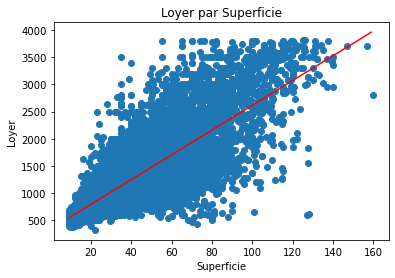

In [8]:
plt.scatter(X_train['Superficie'], y_train)
plt.plot(bins, proj, 'r-')

plt.title('Loyer par Superficie')
plt.xlabel('Superficie')
plt.ylabel('Loyer')

In [9]:
# Try predict a new sample
sup = 105
x_new = np.array([[sup]])
print('pred:', reg.predict(x_new))

px_moy_m2_paris = 33
px_moy_m2_idf = 26
print('expected:', sup * px_moy_m2_idf)

pred: [2730.85424595]
expected: 2730


- Prix moyen (location) m2 Paris 33€ (SeLoger)
- Prix moyen m2 IDF 26€
- With a simple linear regression based on Superficie, the model correctly predicts the average price for 33m2 flats (for Paris m2 price) and 105m2 flats (for IDF m2 price)

## Improve linear regressor v1
- 2 feats linear regressor
- Feats: Superficie, Paris (bool)
- R2 score: 74%


### Split X and y

In [10]:
target = 'Loyer'
features =  ['Superficie', 'Paris']
X_train = rentals_train[features]
y_train = rentals_train[target]

X_test = rentals_test[features]
y_test = rentals_test[target]

### Train and predict with 2 variables linear regression

In [11]:
reg = LinearRegression().fit(X_train, y_train)

In [12]:
print("train", reg.score(X_train, y_train))
print("test", reg.score(X_test, y_test))

train 0.7445044747367022
test 0.7434984064010867


In [13]:
print("Coefs:", reg.coef_.round(2))
print("Intercept:", round(reg.intercept_, 2))

Coefs: [ 23.33 571.52]
Intercept: 14.44


In [14]:
x_new

array([[105]])

In [15]:
# Try predict a new sample
sup = [220, 1]  # 1 for Paris, 0 otherwise
x_new = np.array([sup])
print('pred:', reg.predict(x_new))

px_moy_m2_paris = 33
px_moy_m2_idf = 26
print('expected:', sup[0] * px_moy_m2_paris)
print('expected:', sup[0] * px_moy_m2_idf)

pred: [5717.99585068]
expected: 7260
expected: 5720


- Prix moyen (location) m2 Paris 33€ (SeLoger)
- Prix moyen m2 IDF 26€

- With a simple linear regression based on Superficie and whether the flat is in Paris or not, the model correctly predicts the average price for:
    - 60m2 flats (for Paris m2 price)
    - 220m2 flats (for IDF m2 price)

- It has specialized in Paris prices

## Improve linear regressor v2
- 3 feats linear regressor
- Feats: Superficie, Paris, returns (used as a proxy for Code_postal)
- R2 score: 79%

Trained and tested on areas with returns only (droped NAs)

### Split X and y

In [16]:
rentals_train.columns

Index(['Code_postal', 'Pièces', 'Chambres', 'Superficie', 'Loyer', 'returns',
       'risk', 'ratio', 'Paris'],
      dtype='object')

In [17]:
# Drop na
rentals_train_no_na = rentals_train[~rentals_train['returns'].isna()]
rentals_test_no_na = rentals_test[~rentals_test['returns'].isna()]

In [18]:
target = 'Loyer'
features =  ['Superficie', 'Paris', 'returns']
X_train = rentals_train_no_na[features]
y_train = rentals_train_no_na[target]

X_test = rentals_test_no_na[features]
y_test = rentals_test_no_na[target]

### Train and predict with 3 variables linear regression

In [19]:
reg = LinearRegression().fit(X_train, y_train)

In [20]:
print("train", reg.score(X_train, y_train))
print("test", reg.score(X_test, y_test))

train 0.7883943475243845
test 0.7977031609195676


In [21]:
print("Coefs:", reg.coef_.round(2))
print("Intercept:", round(reg.intercept_, 2))

Coefs: [   26.5    366.66 -4939.76]
Intercept: 323.62


## Tree regressor V0
- 3 feats tree regressor
- Feats: Superficie, Paris, returns (used as a proxy for Code_postal)
- R2 score: 81%

Trained and tested on areas with returns only (droped NAs)

### Split X and y

In [22]:
rentals_train.columns

Index(['Code_postal', 'Pièces', 'Chambres', 'Superficie', 'Loyer', 'returns',
       'risk', 'ratio', 'Paris'],
      dtype='object')

In [23]:
# Drop na
rentals_train_no_na = rentals_train[~rentals_train['returns'].isna()]
rentals_test_no_na = rentals_test[~rentals_test['returns'].isna()]

In [24]:
target = 'Loyer'
features =  ['Superficie', 'Paris', 'returns']
X_train = rentals_train_no_na[features]
y_train = rentals_train_no_na[target]

X_test = rentals_test_no_na[features]
y_test = rentals_test_no_na[target]

### Train and predict with 3 variables tree regression

In [25]:
reg = DecisionTreeRegressor(random_state=0)

In [26]:
cross_val_score(reg, X_train, y_train, cv=10)

array([0.83204939, 0.78410989, 0.83242064, 0.79387243, 0.82466807,
       0.82013681, 0.80529011, 0.79245506, 0.82620423, 0.81444634])

In [27]:
result = cross_validate(reg, X_train, y_train, cv=10, return_estimator=True)

In [28]:
scores = []
for estimator in result['estimator']:
    pred = estimator.predict(X_test)
    score = r2_score(y_test, pred)
    scores.append(score)

avg_score = np.array(scores).mean()

In [29]:
round(avg_score, 2)

0.81

In [30]:
def get_area_metrics(postal_code, data_complete, metrics=['Paris', 'returns', 'risk', 'ratio']):
    """ Get the returns for the given postal_code """
    r = data_complete[data_complete['Code_postal'] == postal_code][metrics].iloc[0]
    return r

In [31]:
postal_code = 75013
superficie = 14

metrics = get_area_metrics(postal_code, rentals_train)
new = np.array([superficie, metrics['Paris'], metrics['returns']])

pred = estimator.predict([new])
pred

array([723.75])

- A 11m2 flat is more expensive in 75013 (670) than in 75016 (594)
- A 14m2 flat is more expensive in 75016 (831) than in 75013 (723)

- Which is not true, 75016 is (almost) systematically more expensive
- Also, prices here are overvalued

## Random Forest V0
- 3 feats random forest regressor
- Feats: Superficie, Paris, returns (used as a proxy for Code_postal)
- R2 score: 85%

Trained and tested on areas with returns only (droped NAs)

### Split X and y

In [32]:
# Drop na
rentals_train_no_na = rentals_train[~rentals_train['returns'].isna()]
rentals_test_no_na = rentals_test[~rentals_test['returns'].isna()]

In [33]:
target = 'Loyer'
features =  ['Superficie', 'Paris', 'returns']
X_train = rentals_train_no_na[features]
y_train = rentals_train_no_na[target]

X_test = rentals_test_no_na[features]
y_test = rentals_test_no_na[target]

### Train and predict with 3 variables RF regression

In [34]:
reg = RandomForestRegressor(max_depth=7, random_state=25)

In [35]:
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, random_state=25)

In [36]:
round(reg.score(X_train, y_train), 2)

0.87

In [37]:
round(reg.score(X_test, y_test), 2)

0.85

In [38]:
def get_area_metrics(postal_code, data_complete, metrics=['Paris', 'returns', 'risk', 'ratio']):
    """ Get the returns for the given postal_code """
    r = data_complete[data_complete['Code_postal'] == postal_code][metrics].iloc[0]
    return r

In [39]:
postal_code = 75013
superficie = 14

metrics = get_area_metrics(postal_code, rentals_train)
new = np.array([superficie, metrics['Paris'], metrics['returns']])

pred = reg.predict([new])
pred

array([744.99307208])

## Random Forest V1
- Large n_feats random forest regressor
- Feats: Superficie, Paris, and Postal codes
- R2 score: ?

Trained and tested on areas with returns only (droped NAs)

### One-hot encode Code_postal

In [40]:
code_postal_dummies = pd.get_dummies(rentals_train['Code_postal'])